In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

from collections import Counter


pd.set_option('display.max_columns', None)

colors_ = sns.color_palette('viridis', 15)

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
path = "../data/"

In [2]:
class MyCounter(Counter):
    def __str__(self):
        return "\n".join('{}: {}'.format(k, v) for k, v in sorted(self.items()))



# <center>Cornerstone for Interpretation</center>

In [3]:
group1 = pd.read_csv(path+"id_vs_frequency_decreasing_ds.csv")
group1 = group1[group1.frequency > 0] # otherwise alpha-R ~ 1
group2 = pd.read_csv(path+"IDs/alpha_one/R_ids_alpha_0.9996.csv")
group3 = pd.read_csv(path+"IDs/alpha_two/R_ids_alpha_1.9930.csv")

DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False)
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

DB2 = pd.read_csv(path+"DB2P8.csv")

# There are shots missing in DB5 from DB2P8
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

### Categorical Data | Preprocessing

In [4]:
TOK_characteristics = ["DIVNAME","WALMAT","DIVMAT","LIMMAT"]
categorical = ["PREMAG","HYBRID","CONFIG","ELMTYPE",
               "ICSCHEME","AUXHEAT","EVAP"] + TOK_characteristics 

DB5[categorical] = DB5[categorical].fillna('UNKNOWN')
DB5["DIVNAME"]   = DB5["DIVNAME"].str.replace("NONAME","UNKNOWN",regex=False)

DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("CC","C",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI1","TI12",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI2","TI12",regex=False)

DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-I)|(DV-IPRE)|(DV-IPOST)",
                                            "DV-I",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-II)|(DV-IIc)|(DV-II-C)|(DV-IIb)|(DV-IIc)|(DV-IId)|(DV-IId)",
                                            "DV-II",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(MARK0)|(MARKI)|(MARKIIA)|(MARKGB)|(MARKGBSR)|"+
                                            "(MARKIA)|(MARKIAP)|(MARKSR)|(MARKA)|(MARKP)",
                                            "MARK",regex=True)

DB5["ICSCHEME"]   = DB5["ICSCHEME"].str.replace("OFF","NONE",regex=False)

DB5["EVAP"] = DB5["EVAP"].str.replace("CARBH","C-H",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("CARB","C",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("BOROC","C-BO",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("(BOROA)|(BOROB)|(BOROX)|(BOR)","BO",regex=True)
#DB5["EVAP"] = DB5["EVAP"].str.replace("DECABOA","C",regex=True)

In [6]:
DB5[DB5.EVAP.isin(['DECABOA'])]#["TOK"].unique()

ind      id    TOK  TOK_ID  DIVNAME    LCUPDATE      DATE   SHOT  \
5740  23821  0F9DIK  JT60U     8.0  UNKNOWN  19961225.0  19950419  23555   
5741  23822  1O6RDZ  JT60U     8.0  UNKNOWN  19961225.0  19950419  23556   
5742  23823  RF3KR1  JT60U     8.0  UNKNOWN  19961225.0  19960315  26177   
5743  23824  UXNCD0  JT60U     8.0  UNKNOWN  19961225.0  19960328  26276   
5744  23825  LCR27L  JT60U     8.0  UNKNOWN  19961225.0  19960904  27377   
5745  23826  6QUR4V  JT60U     8.0  UNKNOWN  20051025.0  19960904  27390   

      TIME  TIME_ID     T1     T2 AUXHEAT   PHASE   HYBRID      ITB ITBTYPE  \
5740   8.5   8500.0  8.475  8.525      NB  HGELMH  UNKNOWN  UNKNOWN     NaN   
5741   8.3   8300.0  8.275  8.325      NB  HGELMH  UNKNOWN  UNKNOWN     NaN   
5742   7.8   7800.0  7.775  7.825      NB  HGELMH  UNKNOWN  UNKNOWN     NaN   
5743   7.4   7400.0  7.375  7.425      NB  HSELMH  UNKNOWN  UNKNOWN     NaN   
5744   6.4   6400.0  6.375  6.425      NB  HGELMH  UNKNOWN  UNKNOWN     NaN   
5745   6.7   6700.0  6.675  6.725      NB  HSELMH  UNKNOWN  UNKNOWN     NaN   

      ELMTYPE  ELMFREQ  ELMMAX  ELMDUR  ELMINT  OLTIME  LHTIME  TPI  ISEQ  \
5740  UNKNOWN      NaN     NaN     NaN     NaN    7.00    8.15  0.0  NONE   
5741  UNKNOWN      NaN     NaN     NaN     NaN    7.00    7.25  0.0  NONE   
5742  UNKNOWN      NaN     NaN     NaN     NaN    5.50    6.75  0.0  NONE   
5743  UNKNOWN      NaN     NaN     NaN     NaN    4.75    5.19  0.0  NONE   
5744  UNKNOWN      NaN     NaN     NaN     NaN    5.00    5.30  0.0  NONE   
5745  UNKNOWN      NaN     NaN     NaN     NaN    5.30    5.40  0.0  NONE   

      MEFF  PGASA  PGASZ  BGASA  BGASZ  BGASA2  BGASZ2 PELLET  FUELRATE  \
5740   2.0    2.0    1.0    2.0    1.0     0.0     0.0   NONE       NaN   
5741   2.0    2.0    1.0    2.0    1.0     0.0     0.0   NONE       NaN   
5742   2.0    2.0    1.0    2.0    1.0     0.0     0.0   NONE       NaN   
5743   2.0    2.0    1.0    2.0    1.0     0.0     0.0   NONE       NaN   
5744   2.0    2.0    1.0    2.0    1.0     0.0     0.0   NONE       NaN   
5745   2.0    2.0    1.0    2.0    1.0     0.0     0.0   NONE       NaN   

      XGASZ  XGASA CONFIG   RGEO   RMAG   AMIN  KAPPA    KAPPAA     KAREA  \
5740    0.0    0.0     SN  3.269  3.351  0.825  1.560  1.467087  1.461547   
5741    0.0    0.0     SN  3.268  3.347  0.811  1.600  1.502689  1.497586   
5742    0.0    0.0     SN  3.364  3.442  0.889  1.343  1.254192  1.227713   
5743    0.0    0.0     SN  3.355  3.416  0.898  1.352  1.251678  1.224993   
5744    0.0    0.0     SN  3.361  3.453  0.889  1.369  1.273928  1.246737   
5745    0.0    0.0     SN  3.357  3.430  0.893  1.371  1.270125  1.242364   

      DELTA  DELTAU  DELTAL  INDENT   AREA    VOL    SURFFORM  SEPLIM  XPLIM  \
5740  0.099     NaN     NaN     0.0  3.137  64.19  139.504578   0.191  0.193   
5741  0.101     NaN     NaN     0.0  3.105  63.54  139.595893   0.198  0.182   
5742  0.347     NaN     NaN     0.0  3.114  64.43  139.786203   0.209  0.201   
5743  0.346     NaN     NaN     0.0  3.171  65.42  141.431430   0.194  0.191   
5744  0.356     NaN     NaN     0.0  3.163  65.37  141.406886   0.201  0.198   
5745  0.361     NaN     NaN     0.0  3.182  65.65  142.009276   0.194  0.194   

     WALMAT DIVMAT LIMMAT     EVAP  DALFMP  DALFDV  IGRADB     BT  IEML  \
5740      C      C      C  DECABOA     NaN     NaN     1.0  1.550   0.0   
5741      C      C      C  DECABOA     NaN     NaN     1.0  2.540   0.0   
5742      C      C      C  DECABOA     NaN     NaN     1.0  1.839   0.0   
5743      C      C      C  DECABOA     NaN     NaN     1.0  3.054   0.0   
5744      C      C      C  DECABOA     NaN     NaN     1.0  1.841   0.0   
5745      C      C      C  DECABOA     NaN     NaN     1.0  3.054   0.0   

       PREMAG     IP  VSURF    Q95  SH95  BEILI2  BEIMHD  BEPMHD    BETMHD  \
5740  UNKNOWN  0.895  0.368  3.027   NaN    1.23     NaN  0.5820  0.007030   
5741  UNKNOWN  1.496  0.257  2.978   NaN    1.13     NaN  0.5780  0.0073

In [7]:
DB5["EVAP"].unique()

array(['NONE', 'C-H', 'BO', 'SILICON', 'C', 'C-BO', 'BE', 'UNKNOWN', 'TI',
       'DECABOA'], dtype=object)

In [8]:
data1 = DB5[DB5.id.isin(group1.id.values)]
data2 = DB5[DB5.id.isin(group2.id.values)]
data3 = DB5[DB5.id.isin(group3.id.values)]

data4 = DB5[DB5.id.isin(DB2.id)]

In [9]:
# Needed for Improved Visualization in Plots

hue_order_ICSCHEME = dict(zip(sorted(data1["ICSCHEME"].unique()), colors_[:len(data1["ICSCHEME"].unique())]))
hue_order_ELMTYPE = dict(zip(sorted(data1["ELMTYPE"].unique()), colors_[:len(data1["ELMTYPE"].unique())]))
hue_order_HYBRID = dict(zip(sorted(data1["HYBRID"].unique()), colors_[:len(data1["HYBRID"].unique())]))
hue_order_AUXHEAT = dict(zip(sorted(data1["AUXHEAT"].unique()), colors_[:len(data1["AUXHEAT"].unique())]))
hue_order_DIVMAT = dict(zip(sorted(data1["DIVMAT"].unique()), colors_[:len(data1["DIVMAT"].unique())]))
hue_order_WALMAT = dict(zip(sorted(data1["WALMAT"].unique()), colors_[:len(data1["WALMAT"].unique())]))
hue_order_EVAP = dict(zip(sorted(data1["EVAP"].unique()), colors_[:len(data1["EVAP"].unique())]))


# <center>General Description per Group</center>

In [10]:
## GROUP 1 -- Decreasing alpha-R the most
print(f"GROUP 1 | size = {len(data1)}")
print(f"Missing Tokamaks: {DB5[~DB5.TOK.isin(data1.TOK.unique())]['TOK'].unique()}")
print(f"Present Tokamaks: {data1.TOK.unique()}")
print("\n")
print(f"ELMTYPE\n{MyCounter(data1['ELMTYPE'])}")
print("\n")
print(f"PHASE\n{MyCounter(data1['PHASE'])}")

GROUP 1 | size = 1486
Missing Tokamaks: ['ASDEX' 'COMPASS' 'JFT2M' 'PBXM' 'PDX' 'TCV' 'TDEV' 'TFTR']
Present Tokamaks: ['AUG' 'AUGW' 'CMOD' 'D3D' 'JET' 'JETILW' 'JT60U' 'MAST' 'NSTX' 'START']


ELMTYPE
TYPE-1+2: 12
TYPE-1+5: 7
TYPE-I: 1023
TYPE-II: 100
TYPE-III: 148
TYPE-RF: 5
TYPE-V: 31
UNKNOWN: 160


PHASE
HGELM: 875
HGELMH: 262
HSELM: 326
HSELMH: 23


In [11]:
## GROUP 2 -- Decreasing alpha-R, but not so much
print(f"GROUP 2 | size = {len(data2)}")
print(f"Missing Tokamaks: {DB5[~DB5.TOK.isin(data2.TOK.unique())]['TOK'].unique()}")
print(f"Present Tokamaks: {data2.TOK.unique()}")
print("\n")
print(f"ELMTYPE\n{MyCounter(data2['ELMTYPE'])}")
print("\n")
print(f"PHASE\n{MyCounter(data2['PHASE'])}")

GROUP 2 | size = 745
Missing Tokamaks: ['ASDEX' 'COMPASS' 'JFT2M' 'PBXM' 'PDX' 'TCV' 'TDEV' 'TFTR']
Present Tokamaks: ['AUG' 'AUGW' 'CMOD' 'D3D' 'JET' 'JETILW' 'JT60U' 'MAST' 'NSTX' 'START']


ELMTYPE
TYPE-1+2: 4
TYPE-1+5: 2
TYPE-I: 523
TYPE-II: 48
TYPE-III: 69
TYPE-V: 18
UNKNOWN: 81


PHASE
HGELM: 445
HGELMH: 136
HSELM: 154
HSELMH: 10


In [12]:
## GROUP 3 -- Doesn't decrease alpha-R
print(f"GROUP 3 | size = {len(data3)}")
print(f"Missing Tokamaks: {DB5[~DB5.TOK.isin(data3.TOK.unique())]['TOK'].unique()}")
print(f"Present Tokamaks: {data3.TOK.unique()}")
print("\n")
print(f"ELMTYPE\n{MyCounter(data3['ELMTYPE'])}")
print("\n")
print(f"PHASE\n{MyCounter(data3['PHASE'])}")

GROUP 3 | size = 45
Missing Tokamaks: ['ASDEX' 'CMOD' 'COMPASS' 'JFT2M' 'JT60U' 'MAST' 'PBXM' 'PDX' 'TCV' 'TDEV'
 'TFTR']
Present Tokamaks: ['AUG' 'AUGW' 'D3D' 'JET' 'JETILW' 'NSTX' 'START']


ELMTYPE
TYPE-I: 33
TYPE-II: 1
TYPE-III: 5
UNKNOWN: 6


PHASE
HGELM: 28
HGELMH: 9
HSELM: 8


In [13]:
## GROUP 4 -- DB2
print(f"GROUP 4 | size = {len(data4)}")
print(f"Missing Tokamaks: {DB5[~DB5.TOK.isin(data4.TOK.unique())]['TOK'].unique()}")
print(f"Present Tokamaks: {data4.TOK.unique()}")
print("\n")
print(f"ELMTYPE\n{MyCounter(data4['ELMTYPE'])}")
print("\n")
print(f"PHASE\n{MyCounter(data4['PHASE'])}")

GROUP 4 | size = 1310
Missing Tokamaks: ['AUGW' 'COMPASS' 'JETILW' 'MAST' 'NSTX' 'START' 'TCV' 'TDEV' 'TFTR']
Present Tokamaks: ['ASDEX' 'AUG' 'CMOD' 'D3D' 'JET' 'JFT2M' 'JT60U' 'PBXM' 'PDX']


ELMTYPE
TYPE-I: 226
TYPE-II: 1
TYPE-III: 16
UNKNOWN: 1067


PHASE
HGELM: 737
HGELMH: 29
HSELM: 542
HSELMH: 2


# <center>Heating Analysis</center>

**VARIABLES**

* `PECRH`: ECRH power absorbed by the plasma
* `PICRH`: iCRH power absorbed by the plasma
* `ICSCHEME`: ICRH heating scheme
* `AUXHEAT`: Type of auxiliary heating
* `ENBI`: Neutral beam energy weighted by power

In [14]:
heating = ["PECRH", "PICRH", "ICSCHEME","AUXHEAT","ENBI"]

### Group 1 | New points in DB5 that are decreasing alpha-R | $\alpha_R \sim 0.6$



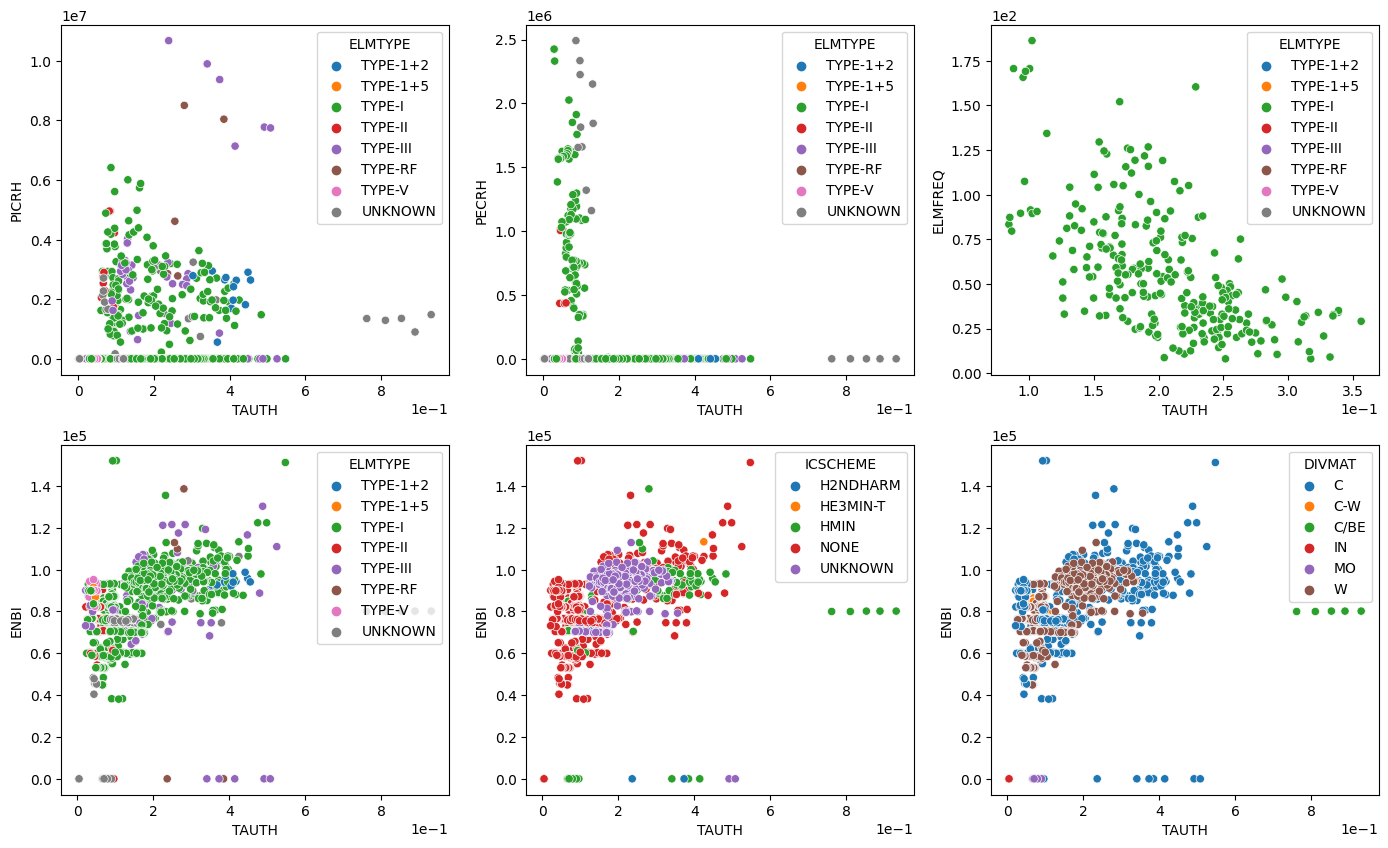

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data1.copy()

sns.scatterplot(data=data_, x="TAUTH", y="PICRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="TAUTH", y="PECRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="TAUTH", y="ELMFREQ", hue="ELMTYPE" ,hue_order=hue_order_ELMTYPE, ax=axs[0,2])

sns.scatterplot(data=data_, x="TAUTH", y="ENBI",hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])
sns.scatterplot(data=data_, x="TAUTH", y="ENBI",hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,1])
sns.scatterplot(data=data_, x="TAUTH", y="ENBI",hue="DIVMAT" ,hue_order=hue_order_DIVMAT, ax=axs[1,2]);

axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0));


### Group 2 | New points in DB5 that are decreasing alpha-R, but not so much | $\alpha_R \sim 1$



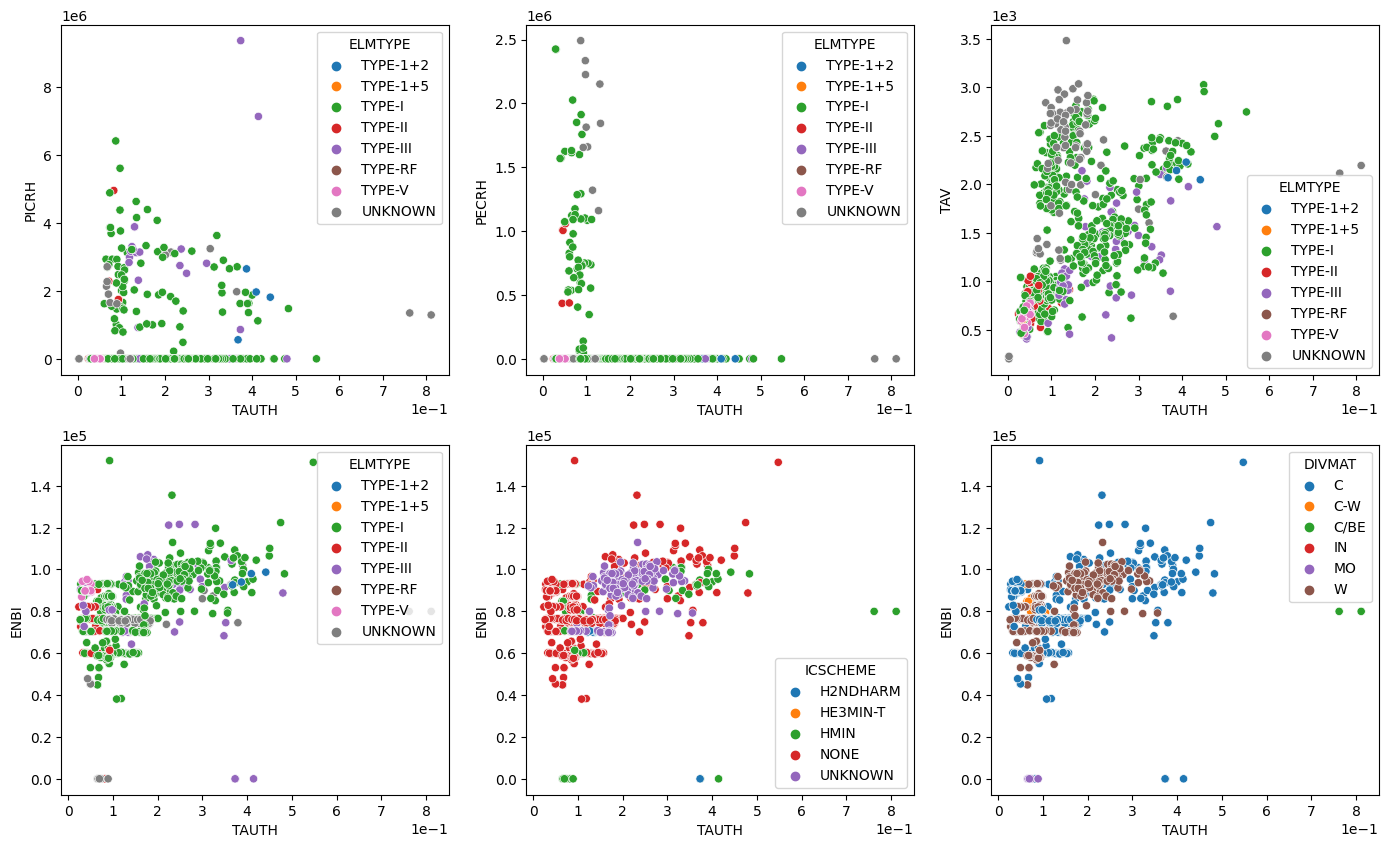

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data2.copy()

sns.scatterplot(data=data_, x="TAUTH", y="PICRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="TAUTH", y="PECRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="TAUTH", y="TAV", hue="ELMTYPE" ,hue_order=hue_order_ELMTYPE, ax=axs[0,2])

sns.scatterplot(data=data_, x="TAUTH", y="ENBI",hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])
sns.scatterplot(data=data_, x="TAUTH", y="ENBI",hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,1])
sns.scatterplot(data=data_, x="TAUTH", y="ENBI",hue="DIVMAT" ,hue_order=hue_order_DIVMAT, ax=axs[1,2]);

axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0));


### Group 3 | New points in DB5 that doesn't decrease alpha-R | $\alpha_R \sim 2$



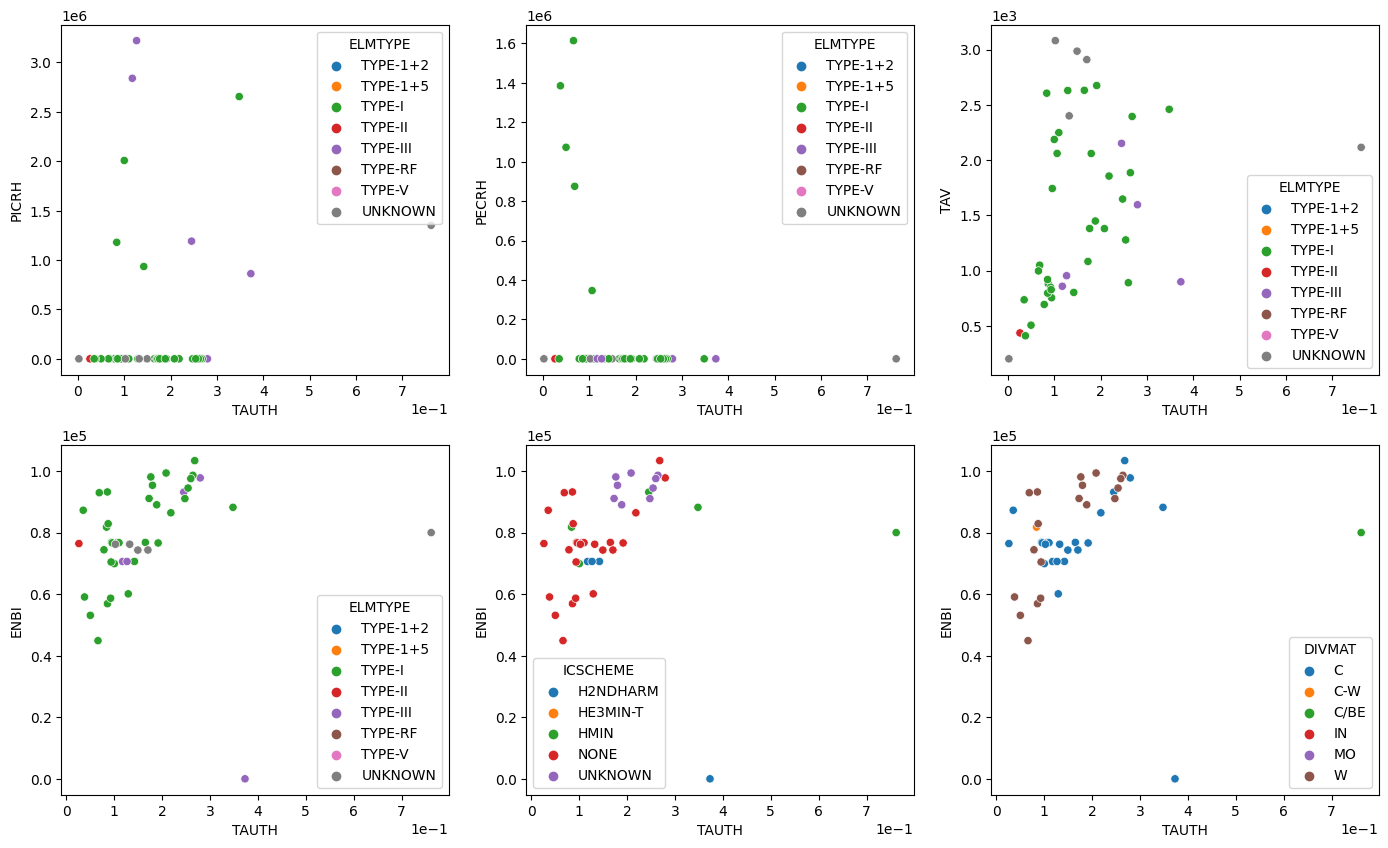

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data3.copy()

sns.scatterplot(data=data_, x="TAUTH", y="PICRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="TAUTH", y="PECRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="TAUTH", y="TAV", hue="ELMTYPE" ,hue_order=hue_order_ELMTYPE, ax=axs[0,2])

sns.scatterplot(data=data_, x="TAUTH", y="ENBI",hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])
sns.scatterplot(data=data_, x="TAUTH", y="ENBI",hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,1])
sns.scatterplot(data=data_, x="TAUTH", y="ENBI",hue="DIVMAT" ,hue_order=hue_order_DIVMAT, ax=axs[1,2]);

axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0));


### Group 4 | DB2 $\alpha_R \sim 2.2$


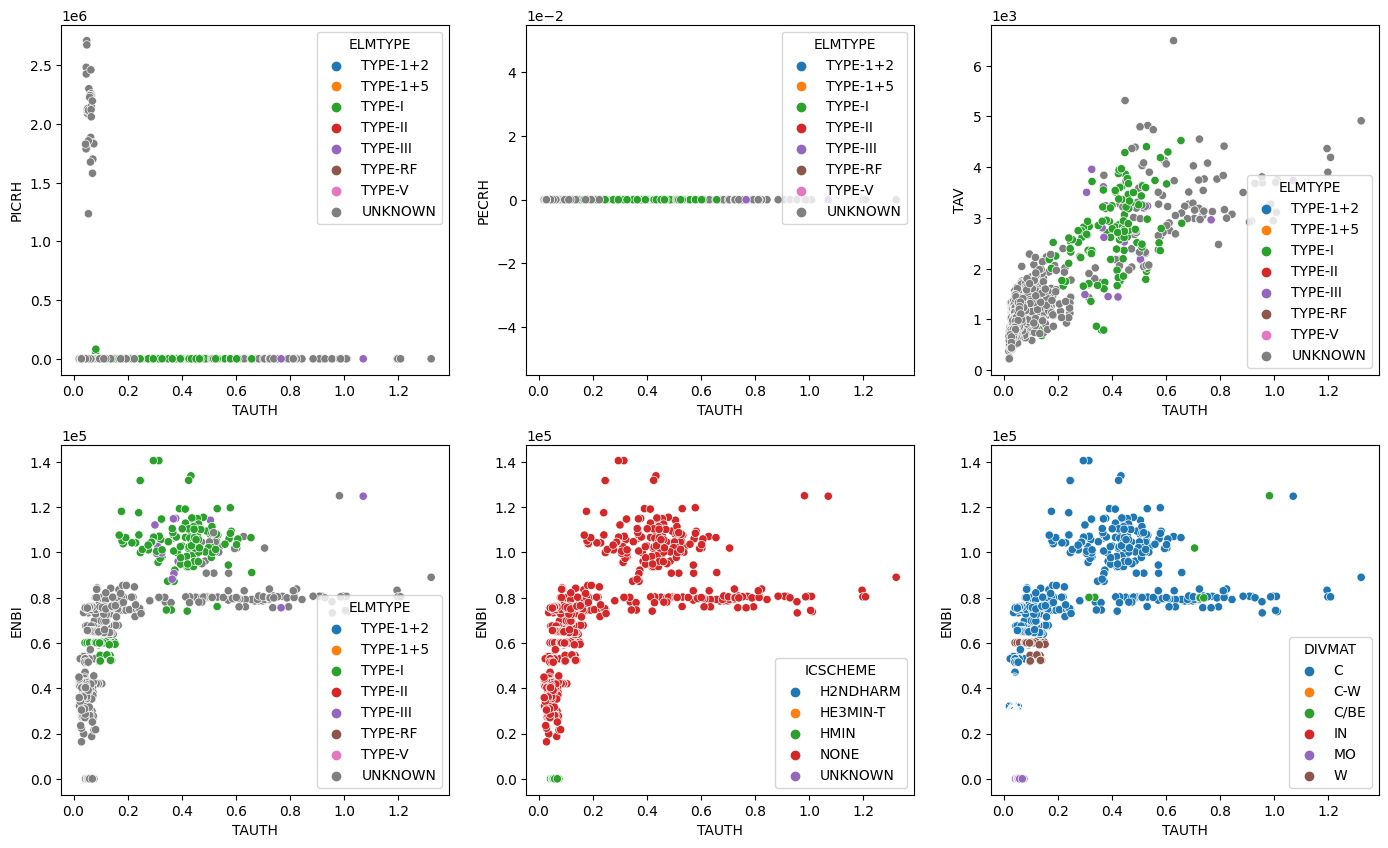

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data4.copy()

sns.scatterplot(data=data_, x="TAUTH", y="PICRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="TAUTH", y="PECRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="TAUTH", y="TAV", hue="ELMTYPE" ,hue_order=hue_order_ELMTYPE, ax=axs[0,2])

sns.scatterplot(data=data_, x="TAUTH", y="ENBI",hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])
sns.scatterplot(data=data_, x="TAUTH", y="ENBI",hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,1])
sns.scatterplot(data=data_, x="TAUTH", y="ENBI",hue="DIVMAT" ,hue_order=hue_order_DIVMAT, ax=axs[1,2]);

axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0));



# <center>Electrons and Fast Ions</center>

Both Entropy Analysis and RF point there is interesting information in fast particles

**VARIABLES**
* `NESOL`: Electron density in scrape-off layer.
* `WFFORM`: Total fast ion energy due to NBI estimated from approximate formula.
* `WFICFORM`:  Total fast ion energy due to ICRH estimated from approximate formula.

In [19]:
fast_particles = ["NESOL","WFFORM","WFICFORM"] 

### Group 1 | New points in DB5 that are decreasing alpha-R | $\alpha_R \sim 0.6$



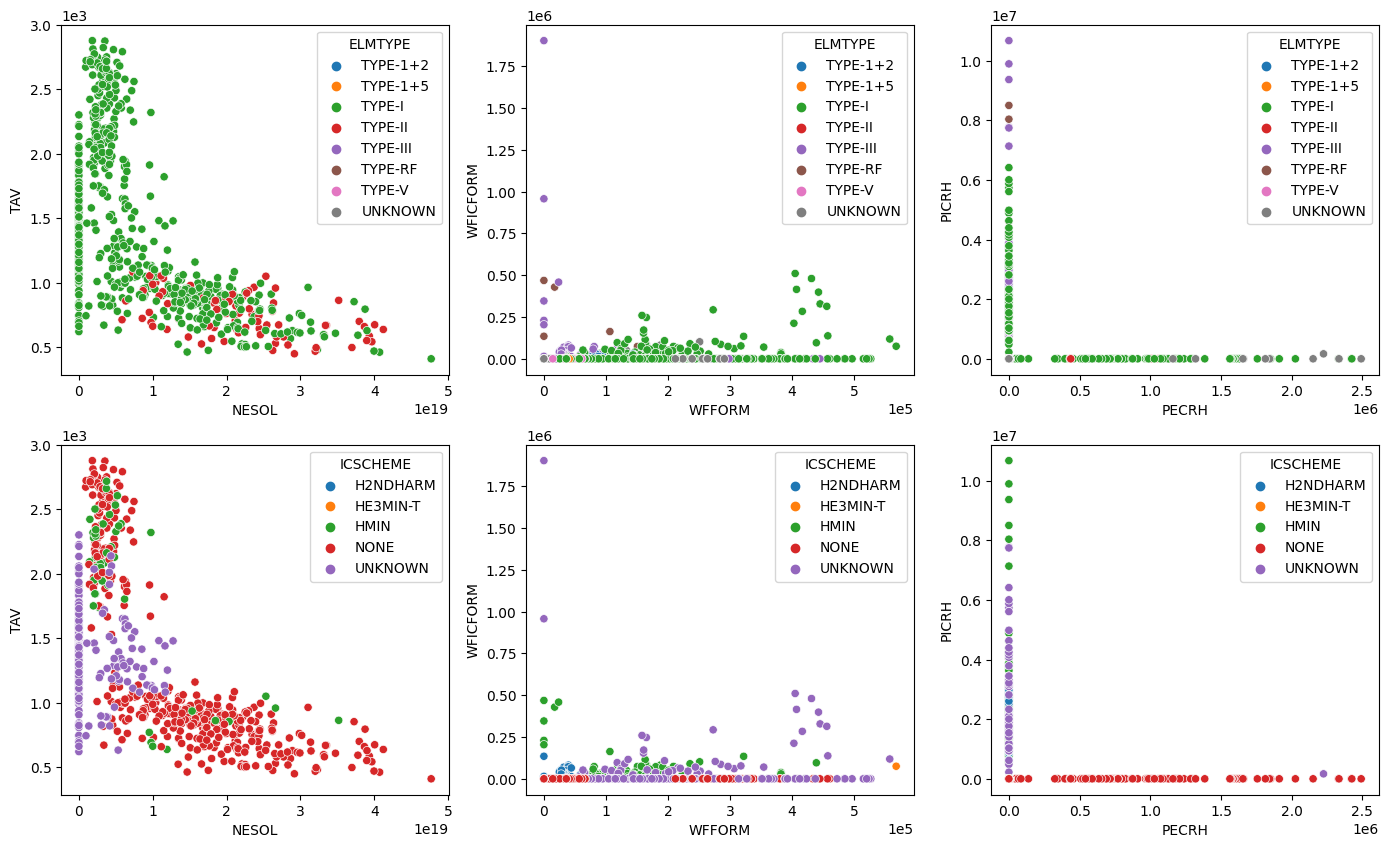

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data1.copy()

sns.scatterplot(data=data_, x="NESOL", y="TAV", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="WFFORM", y="WFICFORM", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="PECRH", y="PICRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,2])

sns.scatterplot(data=data_, x="NESOL", y="TAV", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,0])
sns.scatterplot(data=data_, x="WFFORM", y="WFICFORM", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,1])
sns.scatterplot(data=data_, x="PECRH", y="PICRH", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,2])

axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0));


### Group 2 | New points in DB5 that are decreasing alpha-R, but not so much | $\alpha_R \sim 1$



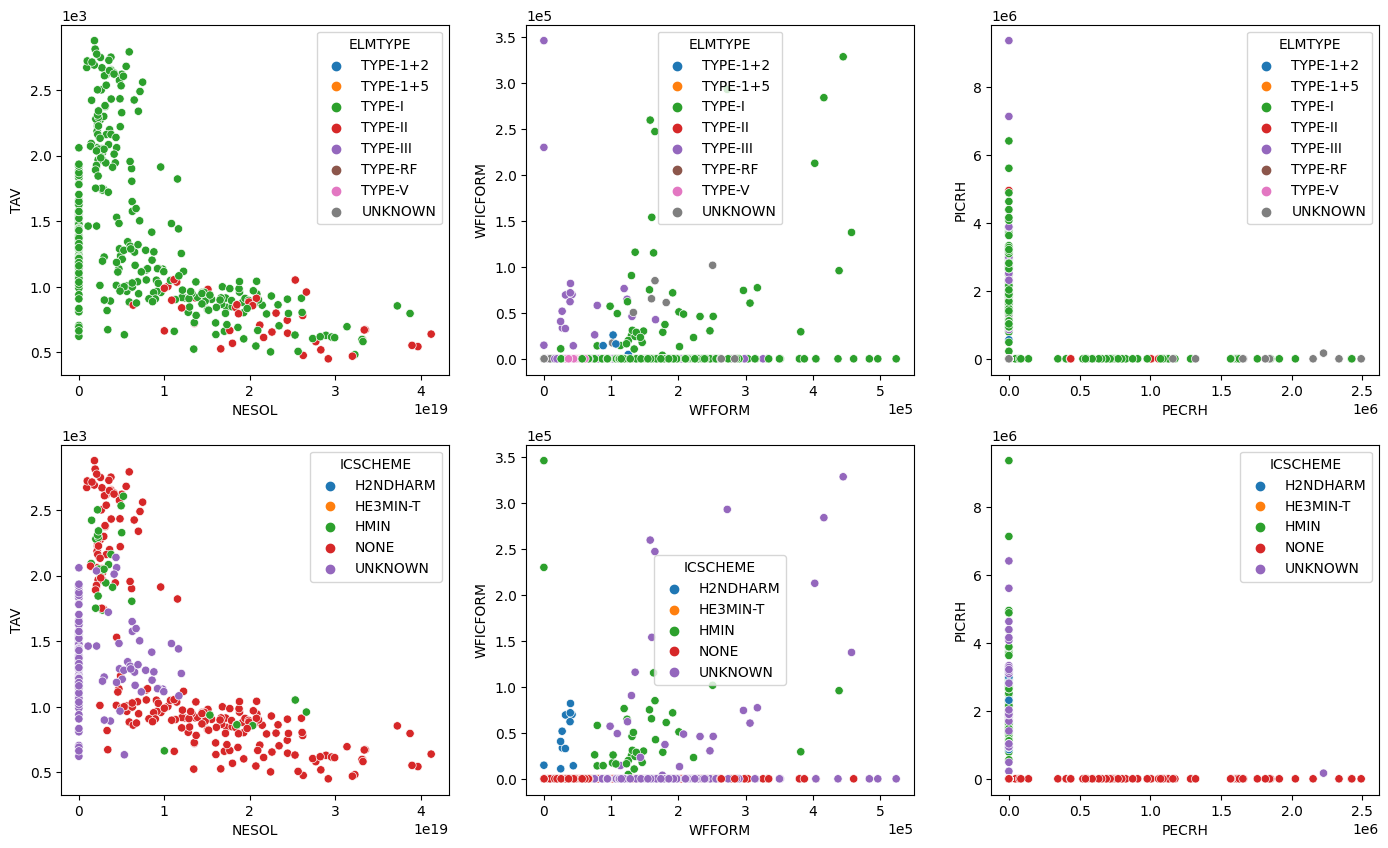

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data2.copy()

sns.scatterplot(data=data_, x="NESOL", y="TAV", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="WFFORM", y="WFICFORM", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="PECRH", y="PICRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,2])

sns.scatterplot(data=data_, x="NESOL", y="TAV", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,0])
sns.scatterplot(data=data_, x="WFFORM", y="WFICFORM", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,1])
sns.scatterplot(data=data_, x="PECRH", y="PICRH", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,2])

axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0));


### Group 3 | New points in DB5 that doesn't decrease alpha-R | $\alpha_R \sim 2$



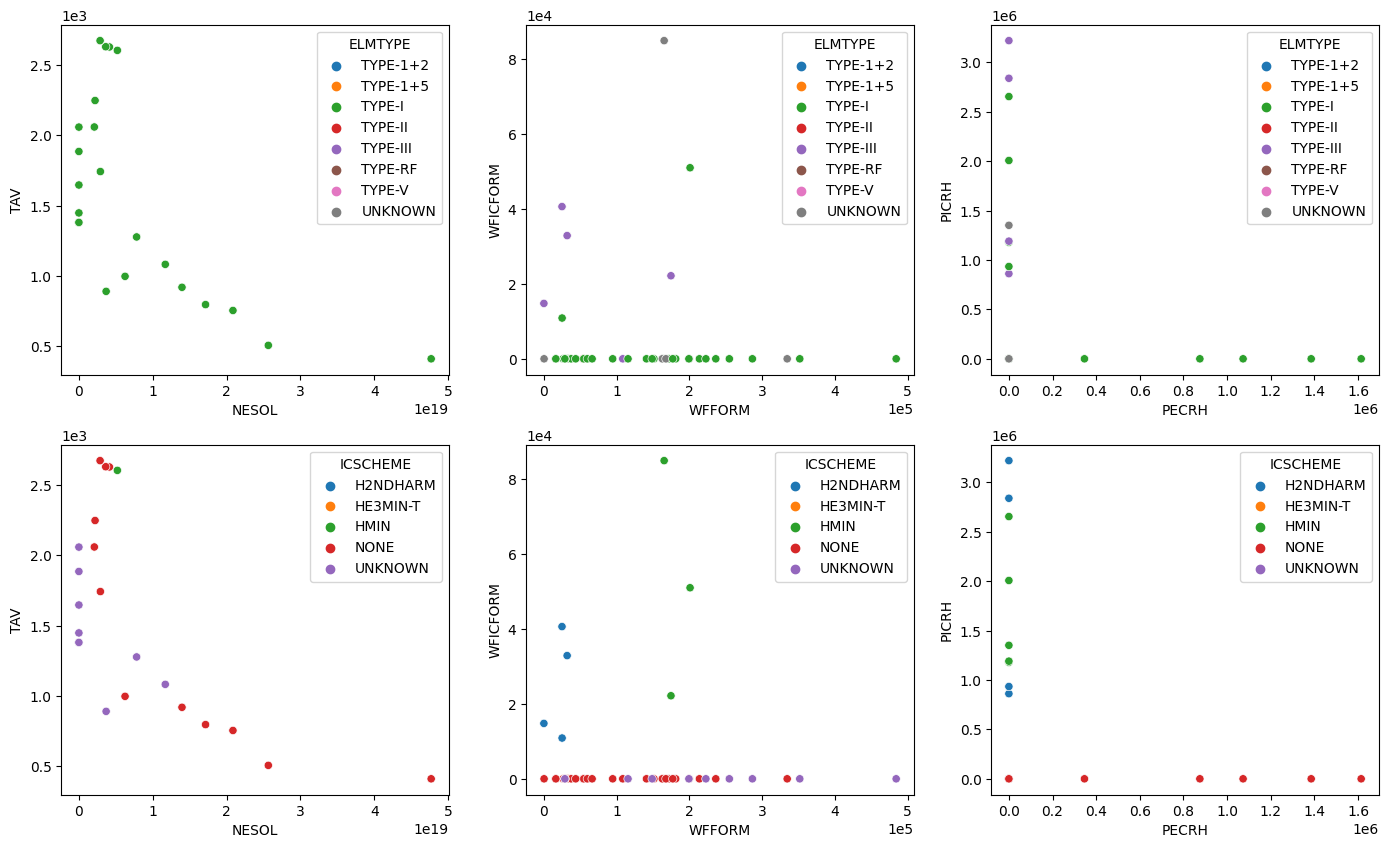

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data3.copy()

sns.scatterplot(data=data_, x="NESOL", y="TAV", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="WFFORM", y="WFICFORM", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="PECRH", y="PICRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,2])

sns.scatterplot(data=data_, x="NESOL", y="TAV", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,0])
sns.scatterplot(data=data_, x="WFFORM", y="WFICFORM", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,1])
sns.scatterplot(data=data_, x="PECRH", y="PICRH", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,2])
axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))

axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0));


### Group 4 | DB2 $\alpha_R \sim 2.2$


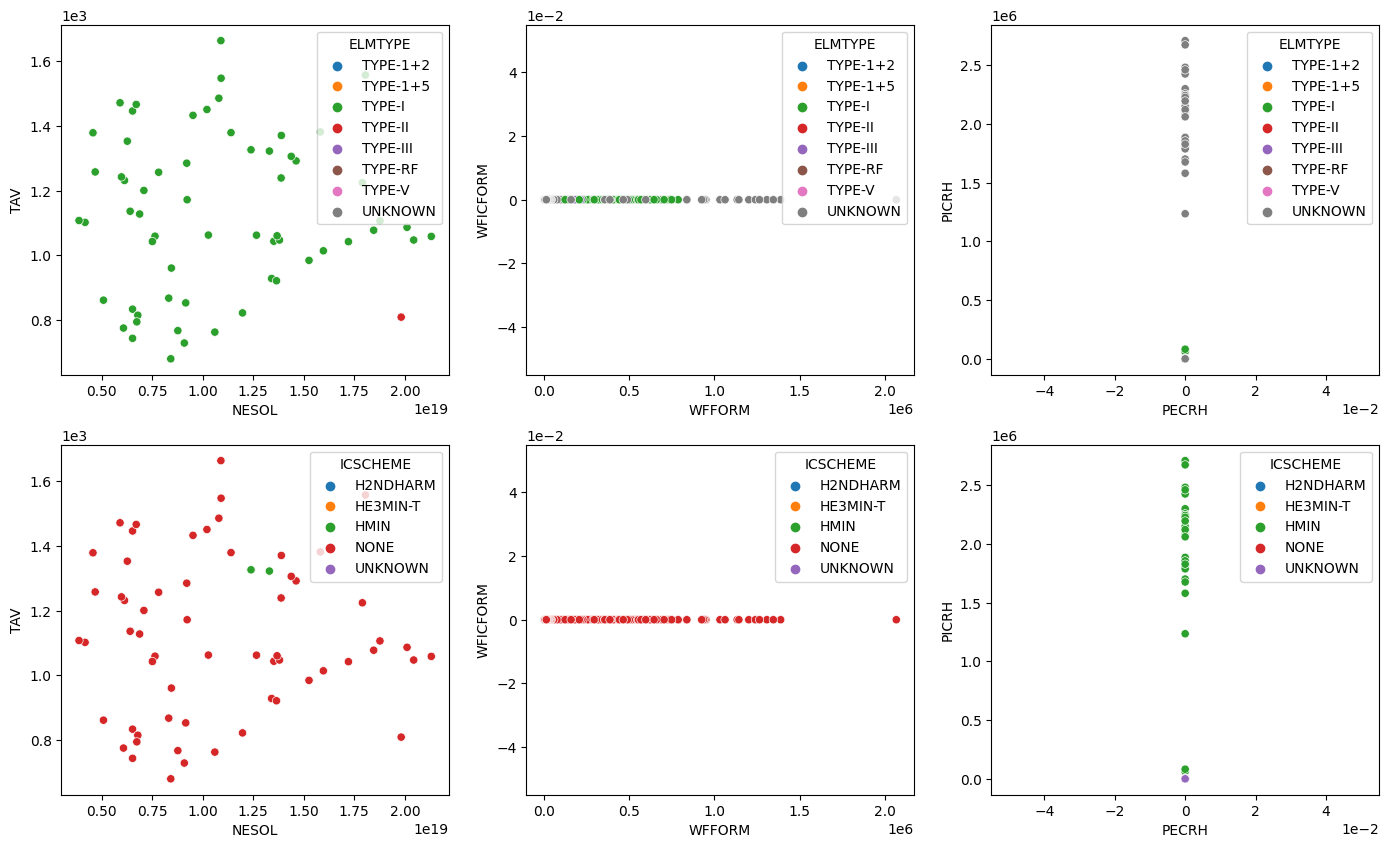

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data4.copy()

sns.scatterplot(data=data_, x="NESOL", y="TAV", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="WFFORM", y="WFICFORM", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="PECRH", y="PICRH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,2])

sns.scatterplot(data=data_, x="NESOL", y="TAV", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,0])
sns.scatterplot(data=data_, x="WFFORM", y="WFICFORM", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,1])
sns.scatterplot(data=data_, x="PECRH", y="PICRH", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,2])

axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,2].ticklabel_format(style='sci', axis='both', scilimits=(0,0));

# <center>Plasma Properties</center>

**VARIABLES**
* `QCYL5`: Cylindrical, the plasma safety factor at the 95% poloidal flux surface. .
* `BEIMHD`: Beta Shafranov. 
* `PREMAG`: Indicates if startup was done with or without pre-magnetization current.
* `LHTIME`: The time of the L to H transition.
* `HYBRID`: Flag for indicating whether the time point is a HYBRID mode.
* `CONFIG`: The plasma configuration.
* `DWDIA`: Time rate of change of the total plasma stored energy.
* `WMHD`: Total plasma energy as determined by MHD equilibrium calculations
* `TORQ`:  Torque on plasma due to neutral beam injection from formula.

In [24]:
plasma_characteristics = ["QCYL5","BEIMHD","PREMAG","LHTIME","HYBRID",
                          "CONFIG","DWDIA","WMHD","TORQ"] 

### Group 1 | New points in DB5 that are decreasing alpha-R | $\alpha_R \sim 0.6$


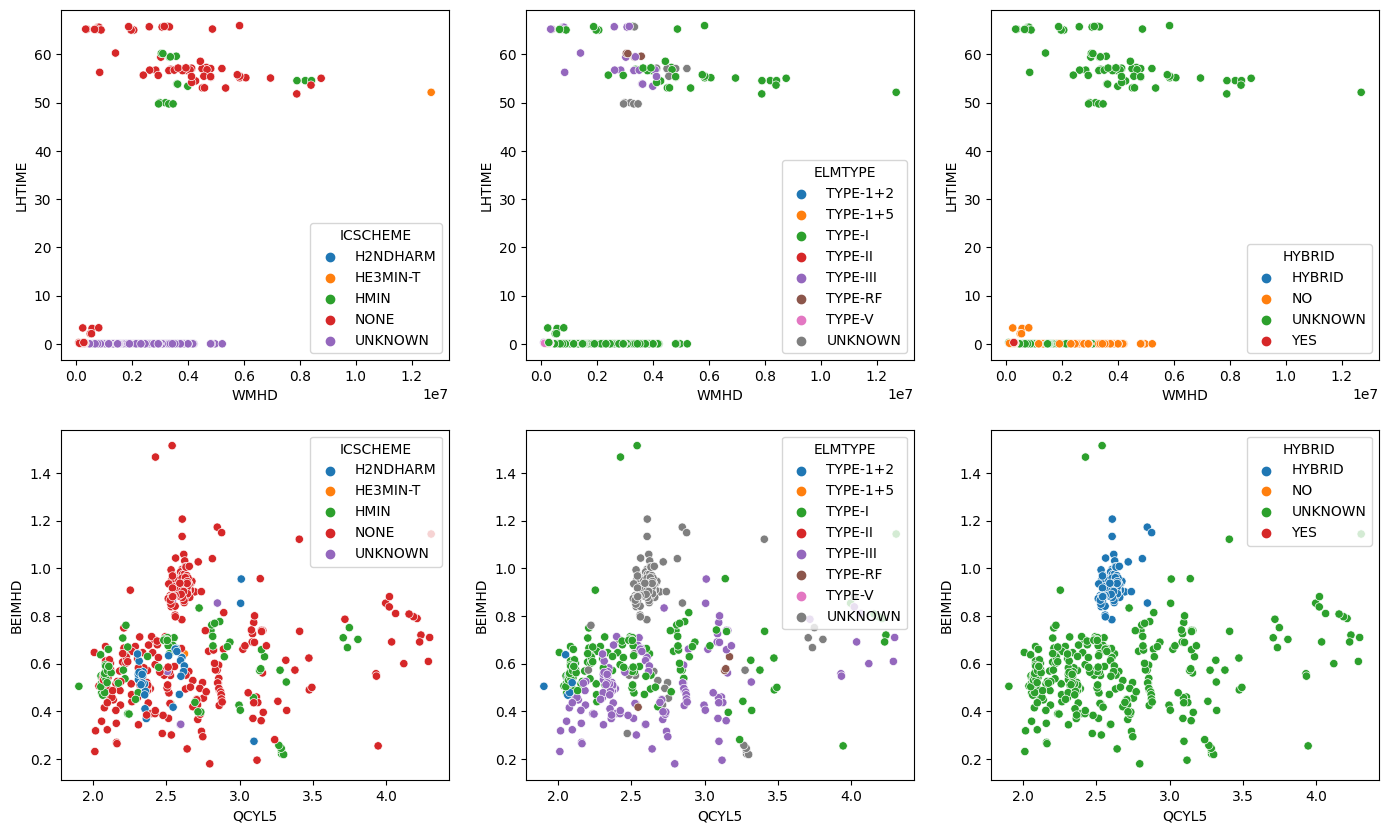

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data1.copy()

sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[0,0])
sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[0,2])

sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,0])
sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[1,1])
sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[1,2]);

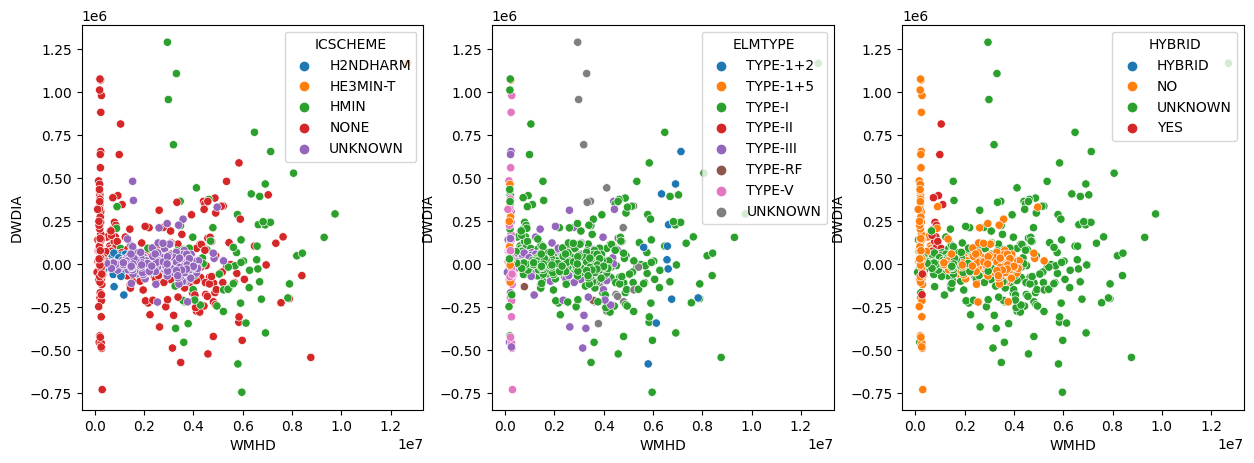

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

data_ = data1.copy()

sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[0])
sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[1])
sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[2]);


### Group 2 | New points in DB5 that are decreasing alpha-R, but not so much | $\alpha_R \sim 1$



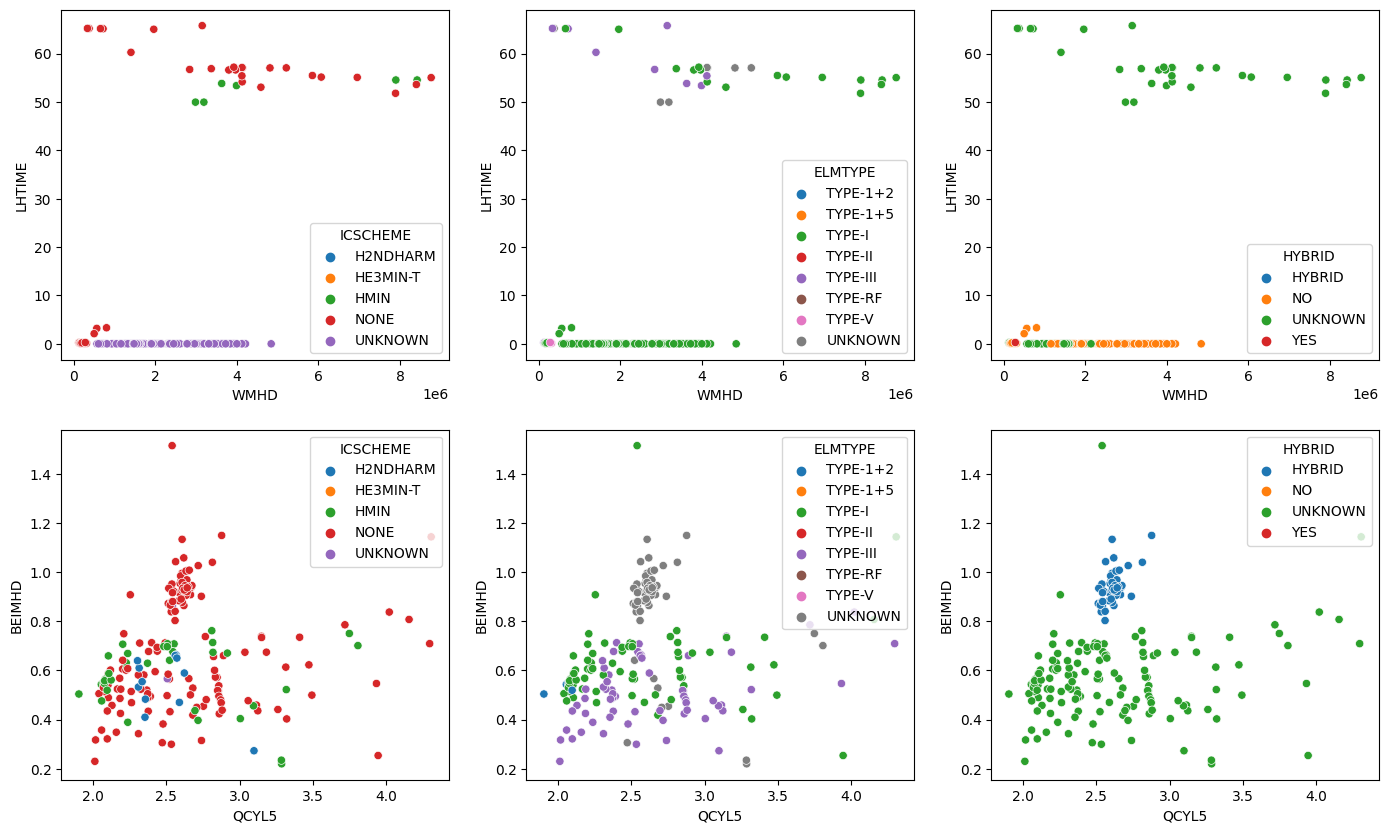

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data2.copy()

sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[0,0])
sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[0,2])

sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,0])
sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[1,1])
sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[1,2]);

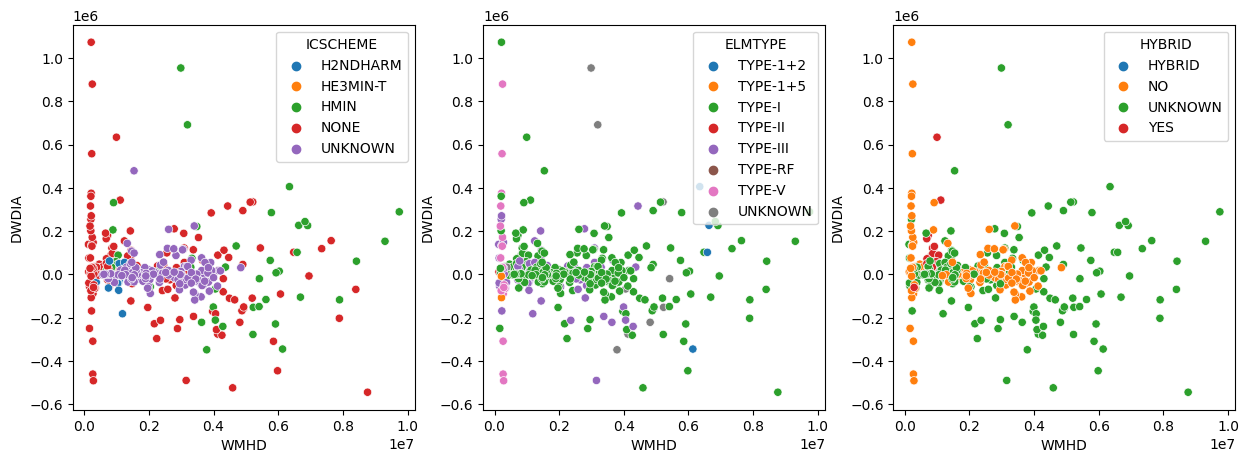

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

data_ = data2.copy()

sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[0])
sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[1])
sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[2]);


### Group 3 | New points in DB5 that doesn't decrease alpha-R | $\alpha_R \sim 2$


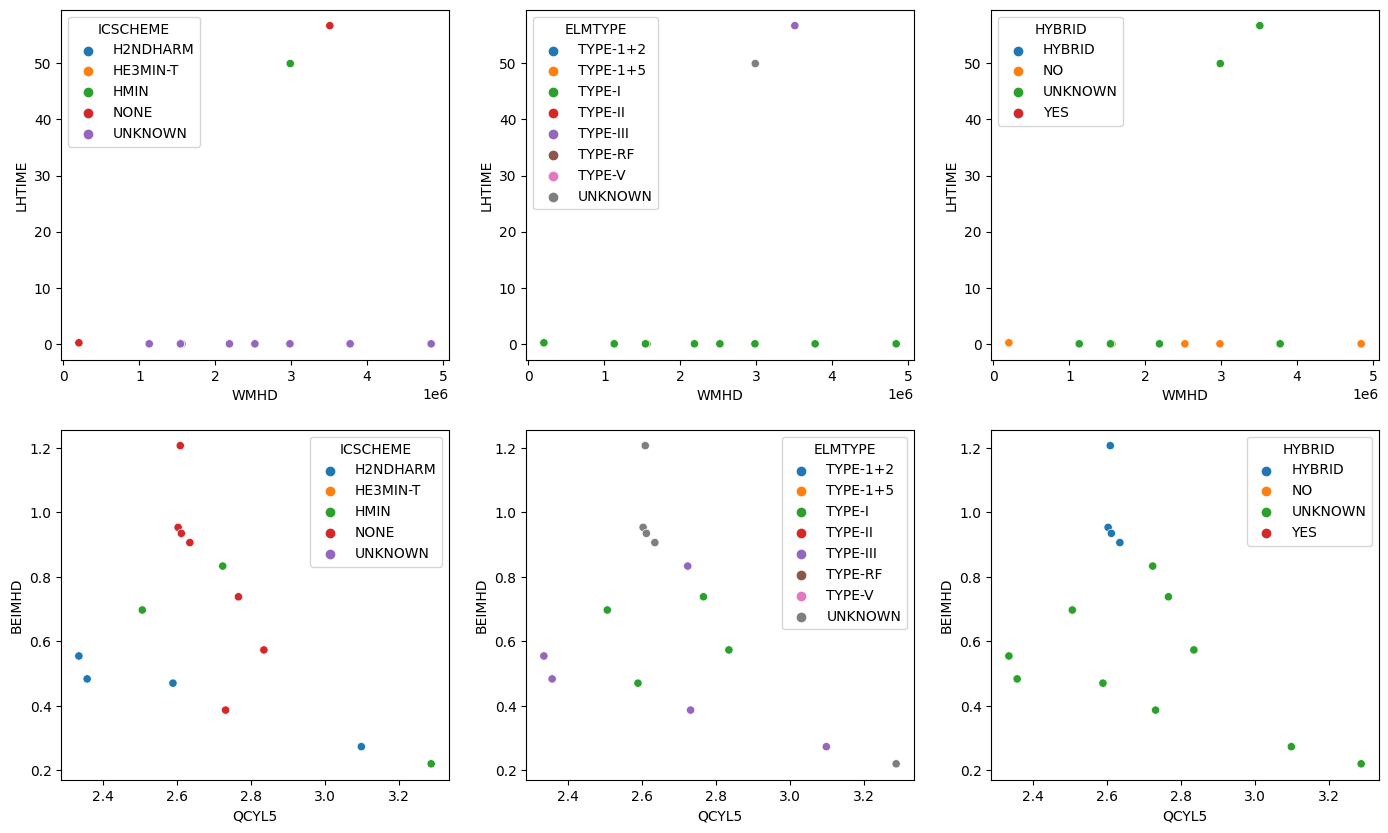

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data3.copy()

sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[0,0])
sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[0,2])

sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,0])
sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[1,1])
sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[1,2]);

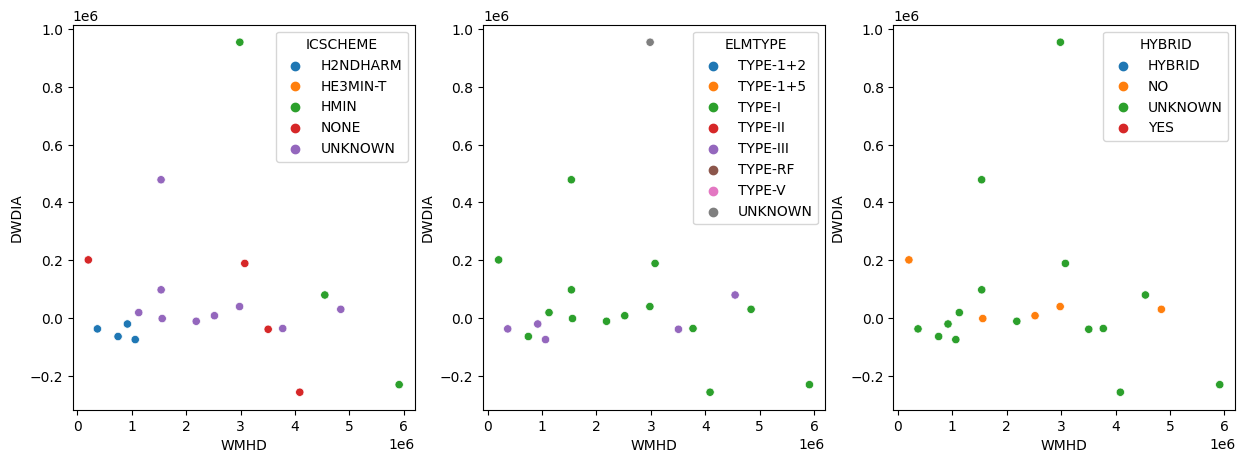

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

data_ = data3.copy()

sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[0])
sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[1])
sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[2]);


### Group 4 | DB2 $\alpha_R \sim 2.2$


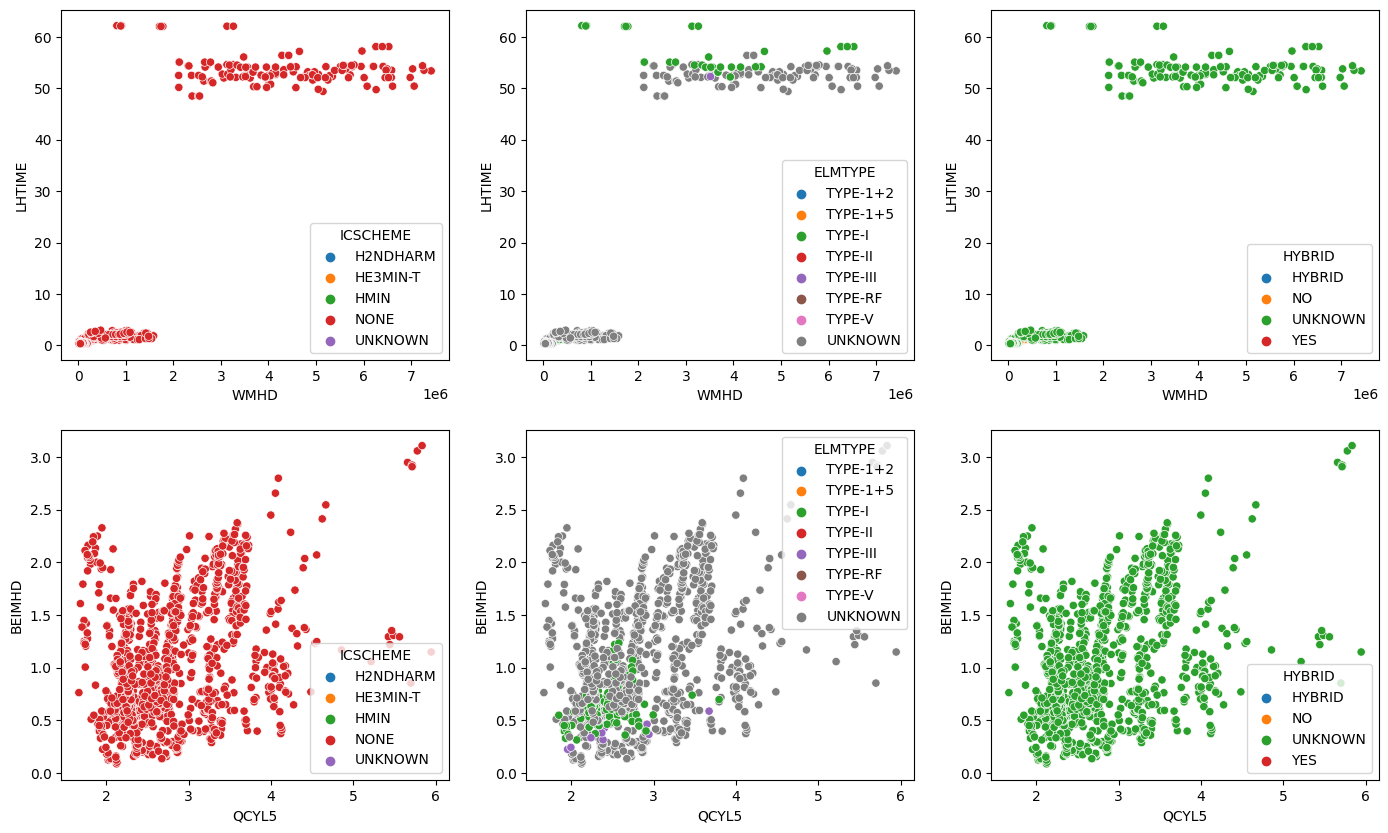

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data4.copy()

sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[0,0])
sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data_, x="WMHD", y="LHTIME", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[0,2])

sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[1,0])
sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[1,1])
sns.scatterplot(data=data_, x="QCYL5", y="BEIMHD", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[1,2]);

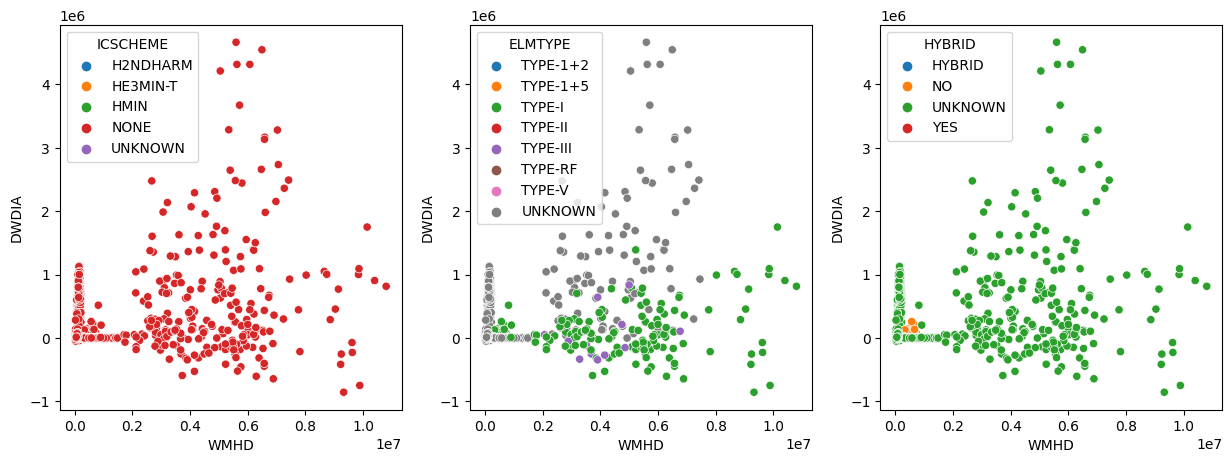

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

data_ = data4.copy()

sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="ICSCHEME",hue_order=hue_order_ICSCHEME, ax=axs[0])
sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="ELMTYPE", hue_order=hue_order_ELMTYPE, ax=axs[1])
sns.scatterplot(data=data_, x="WMHD", y="DWDIA", hue="HYBRID",hue_order=hue_order_HYBRID, ax=axs[2]);

# <center>Contamination and Materials</center>

**IMPURITIES VARIABLES**

* `EVAP`: The evaporated material used to cover the inside of the vessel. 
* `ZEFF`: Line average plasma effective charge determined from visible Bremsstrahlung.
* `ZEFFNEO`: Plasma effective charge as determined by neo-classical resistivity.
* `PRAD`: Total radiated power as measured by Bolometer. 

**TOKAMAK VARIABLES**

* `TOK`:  This variable designates which tokamak has supplied the data.
* `DIVNAME`: Describes each device's divertor configuration.
* `WALMAT`:  The material of the vessel wall.
* `DIVMAT`: The material of the divertor tiles.
* `LIMMAT`: The material of the limiters.

In [33]:
impurities = ["EVAP","ZEFF","ZEFFNEO","PRAD","ENBI"]
TOK_characteristics = ["TOK","DIVNAME","WALMAT","DIVMAT","LIMMAT"]

### Group 1 | New points in DB5 that are decreasing alpha-R | $\alpha_R \sim 0.6$


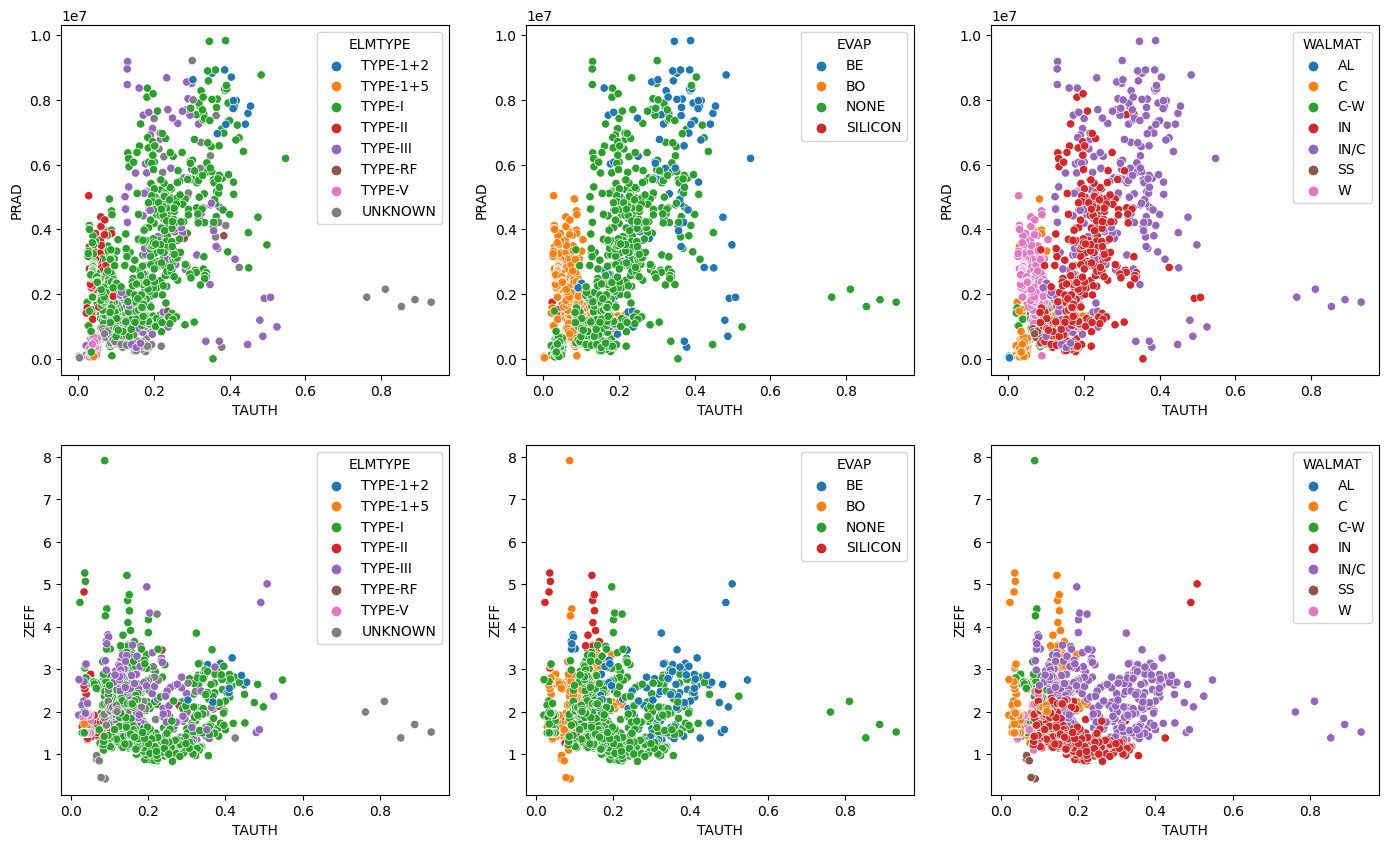

In [34]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data1.copy()

sns.scatterplot(data=data_, x="TAUTH", y="PRAD", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="TAUTH", y="PRAD", hue="EVAP", hue_order=hue_order_EVAP, ax=axs[0,1])
sns.scatterplot(data=data_, x="TAUTH", y="PRAD", hue="WALMAT",hue_order=hue_order_WALMAT, ax=axs[0,2])

sns.scatterplot(data=data_, x="TAUTH", y="ZEFF", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])
sns.scatterplot(data=data_, x="TAUTH", y="ZEFF", hue="EVAP", hue_order=hue_order_EVAP, ax=axs[1,1])
sns.scatterplot(data=data_, x="TAUTH", y="ZEFF", hue="WALMAT",hue_order=hue_order_WALMAT, ax=axs[1,2]);

### Group 2 | New points in DB5 that are decreasing alpha-R, but not so much | $\alpha_R \sim 1$


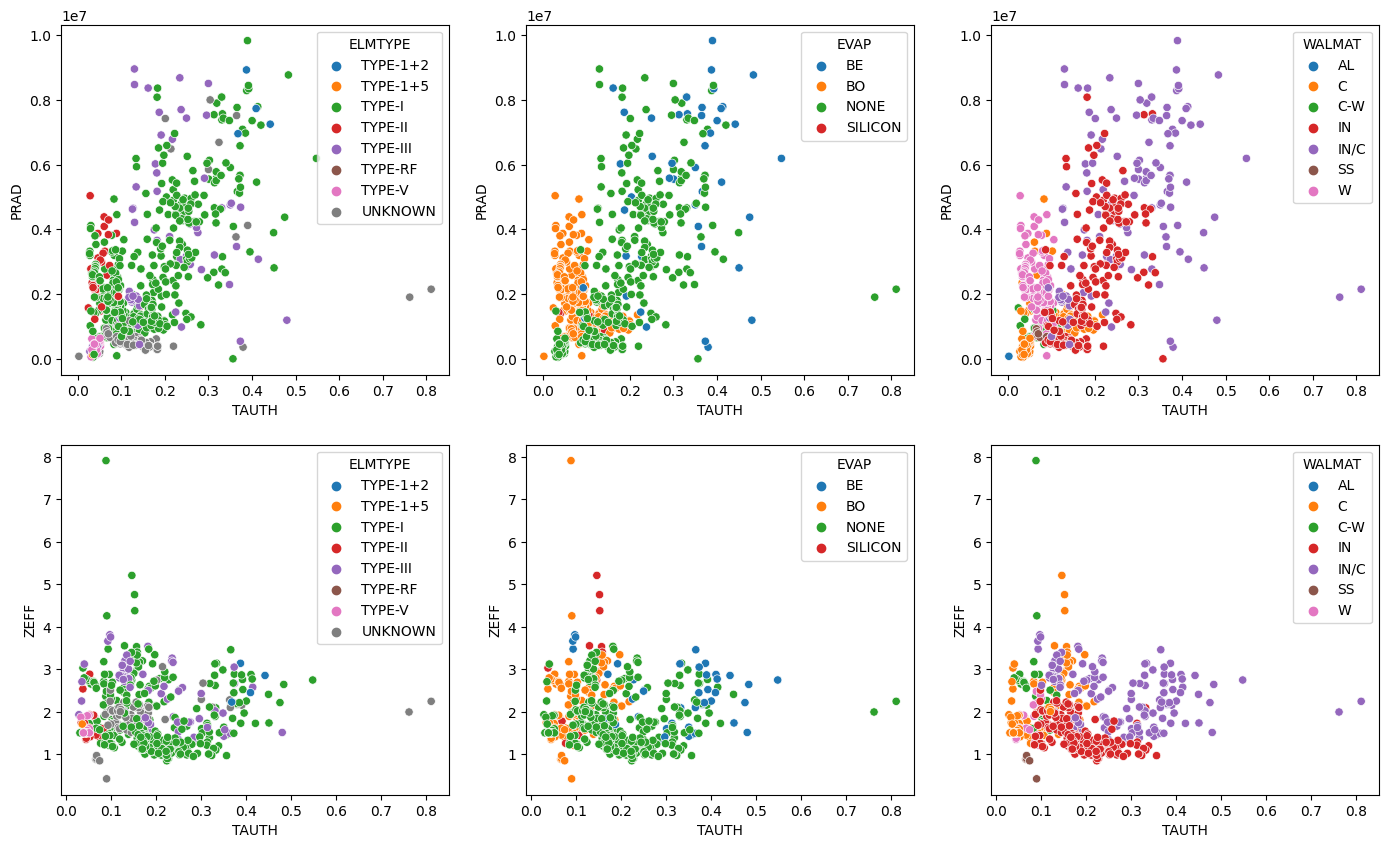

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data2.copy()

sns.scatterplot(data=data_, x="TAUTH", y="PRAD", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="TAUTH", y="PRAD", hue="EVAP", hue_order=hue_order_EVAP, ax=axs[0,1])
sns.scatterplot(data=data_, x="TAUTH", y="PRAD", hue="WALMAT",hue_order=hue_order_WALMAT, ax=axs[0,2])

sns.scatterplot(data=data_, x="TAUTH", y="ZEFF", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])
sns.scatterplot(data=data_, x="TAUTH", y="ZEFF", hue="EVAP", hue_order=hue_order_EVAP, ax=axs[1,1])
sns.scatterplot(data=data_, x="TAUTH", y="ZEFF", hue="WALMAT",hue_order=hue_order_WALMAT, ax=axs[1,2]);


### Group 3 | New points in DB5 that doesn't decrease alpha-R | $\alpha_R \sim 2$



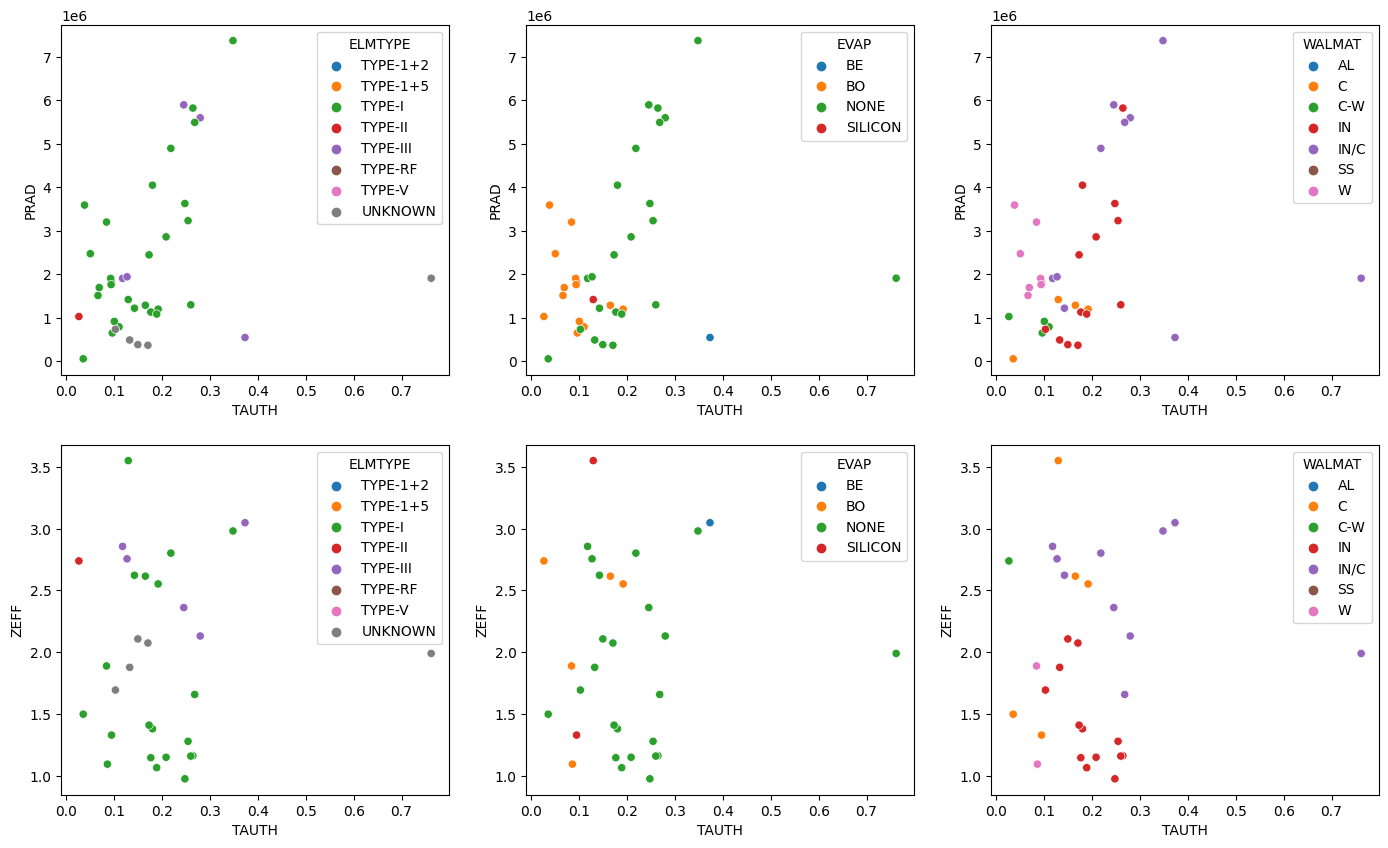

In [36]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data3.copy()

sns.scatterplot(data=data_, x="TAUTH", y="PRAD", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="TAUTH", y="PRAD", hue="EVAP", hue_order=hue_order_EVAP, ax=axs[0,1])
sns.scatterplot(data=data_, x="TAUTH", y="PRAD", hue="WALMAT",hue_order=hue_order_WALMAT, ax=axs[0,2])

sns.scatterplot(data=data_, x="TAUTH", y="ZEFF", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])
sns.scatterplot(data=data_, x="TAUTH", y="ZEFF", hue="EVAP", hue_order=hue_order_EVAP, ax=axs[1,1])
sns.scatterplot(data=data_, x="TAUTH", y="ZEFF", hue="WALMAT",hue_order=hue_order_WALMAT, ax=axs[1,2]);


### Group 4 | DB2 | $\alpha_R \sim 2.2$


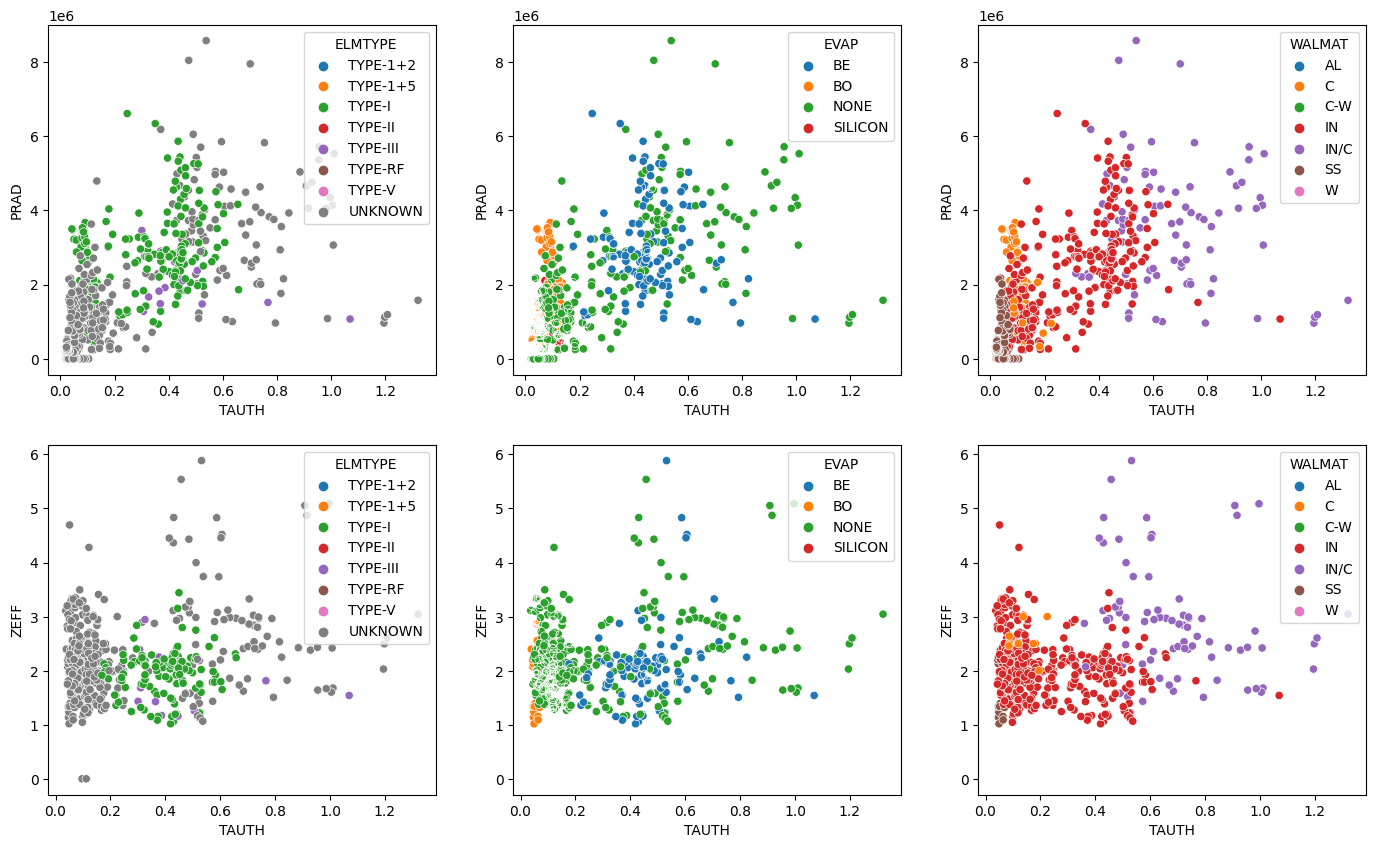

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

data_ = data4.copy()

sns.scatterplot(data=data_, x="TAUTH", y="PRAD", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data_, x="TAUTH", y="PRAD", hue="EVAP", hue_order=hue_order_EVAP, ax=axs[0,1])
sns.scatterplot(data=data_, x="TAUTH", y="PRAD", hue="WALMAT",hue_order=hue_order_WALMAT, ax=axs[0,2])

sns.scatterplot(data=data_, x="TAUTH", y="ZEFF", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])
sns.scatterplot(data=data_, x="TAUTH", y="ZEFF", hue="EVAP", hue_order=hue_order_EVAP, ax=axs[1,1])
sns.scatterplot(data=data_, x="TAUTH", y="ZEFF", hue="WALMAT",hue_order=hue_order_WALMAT, ax=axs[1,2]);

# <center>Power</center>

**VARIABLES**

* `POHM`: Total Ohmic power. 